In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy import stats
from numpy.polynomial.polynomial import Polynomial

## Functions

### Plot method

In [3]:
def plot_vote_share_vs_population(df, population_col, dem_col, rep_col, degree):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=df,
        x=population_col,
        y=dem_col,
        color='blue',
        label='Democratic Vote Share',
        alpha=0.6
    )
    sns.scatterplot(
        data=df,
        x=population_col,
        y=rep_col,
        color='red',
        label='Republican Vote Share',
        alpha=0.6
    )

    democratic_poly = Polynomial.fit(df[population_col], df[dem_col], deg=degree)
    x_vals = np.linspace(df[population_col].min(), df[population_col].max(), 100)
    plt.plot(x_vals, democratic_poly(x_vals), color='blue', label='Democratic Line')

    republican_poly = Polynomial.fit(df[population_col], df[rep_col], deg=degree)
    plt.plot(x_vals, republican_poly(x_vals), color='red', label='Republican Line')

    # Customize plot
    plt.title('Non-Linear Vote Share vs Population Percentage', fontsize=16)
    plt.xlabel(f'{population_col}', fontsize=14)
    plt.ylabel('Vote Share', fontsize=14)
    plt.legend(title="Vote Share", fontsize=12)
    plt.grid(alpha=0.3)

    # Show plot
    plt.show()

### Main Function and declaration

In [4]:
brackets = {
    "0_35K": 17500,
    "35K_60K": 47500,
    "60K_100K": 80000,
    "100K_125K": 112500,
    "125K_150K": 137500,
    "150K_MORE": 150000
}

In [5]:
def calculate_avg_income(row):
    total_income = 0
    total_households = 0
    for bracket, midpoint in brackets.items():
        total_income += row[bracket] * midpoint
        total_households += row[bracket]
    return total_income / total_households if total_households > 0 else 0

In [ ]:
def process_population_vote_share(race_df, election_df, region_type_df, econ_df, target_population_col_name, population_col):

    election_df['Republican_Vote_Share'] = (election_df['TOT_REP'] / election_df['TOT_VOT']) * 100
    election_df['Democratic_Vote_Share'] = (election_df['TOT_DEM'] / election_df['TOT_VOT']) * 100
    race_df[target_population_col_name] = (race_df[population_col] / race_df['TOT_POP22']) * 100
    econ_df['Avg_Household_Income'] = econ_df.apply(calculate_avg_income, axis=1)

    merged_df = pd.merge(election_df, race_df, on='UNIQUE_ID', how='inner')
    merged_df = pd.merge(merged_df, region_type_df, on='UNIQUE_ID', how='inner')
    merged_df = pd.merge(merged_df, econ_df, on='UNIQUE_ID', how='inner')

    columns_to_keep = ['UNIQUE_ID', 'Republican_Vote_Share', 'Democratic_Vote_Share', target_population_col_name, 'Avg_Household_Income', 'region_type']
    merged_df = merged_df[columns_to_keep]
    merged_df = merged_df.dropna(subset=[target_population_col_name, 'Democratic_Vote_Share', 'Republican_Vote_Share'])
    # remove outliers
    merged_df = merged_df[(merged_df[target_population_col_name] != 0.0) & (merged_df[target_population_col_name] != 100.0)]
    merged_df = merged_df[(merged_df['Republican_Vote_Share'] != 0.0) & (merged_df['Republican_Vote_Share'] != 100.0)]
    merged_df = merged_df[(merged_df['Democratic_Vote_Share'] != 0.0) & (merged_df['Democratic_Vote_Share'] != 100.0)]
    return merged_df

## Import data

In [7]:
sc_election_gov_df = pd.read_json('states/south_carolina/election/sc_election_gov_22.json')
sc_race_df = pd.read_json('states/south_carolina/demographics/south_carolina_precincts_racial_population.json')
sc_region_type_df = pd.read_json('states/south_carolina/geodata/south_carolina_precincts_region_type.json')
sc_econ_df = pd.read_json('states/south_carolina/economic/south_carolina_precincts_household_income.json')

## Main script

In [8]:
white_pop_vote_share_df = process_population_vote_share(sc_race_df, sc_election_gov_df, sc_region_type_df, sc_econ_df, 'White_Pop_Percent', 'WHT_NHSP22')
black_pop_vote_share_df = process_population_vote_share(sc_race_df, sc_election_gov_df, sc_region_type_df, sc_econ_df, 'Black_Pop_Percent', 'BLK_NHSP22')
asian_pop_vote_share_df = process_population_vote_share(sc_race_df, sc_election_gov_df, sc_region_type_df, sc_econ_df, 'Asian_Pop_Percent', 'ASN_NHSP22')
hispanic_pop_vote_share_df = process_population_vote_share(sc_race_df, sc_election_gov_df, sc_region_type_df, sc_econ_df, 'Hispanic_Pop_Percent', 'HPI_NHSP22')

### Export to JSON

In [9]:
white_pop_vote_share_list = white_pop_vote_share_df.to_dict(orient='records')
black_pop_vote_share_list = black_pop_vote_share_df.to_dict(orient='records')
asian_pop_vote_share_list = asian_pop_vote_share_df.to_dict(orient='records')
hispanic_pop_vote_share_list = hispanic_pop_vote_share_df.to_dict(orient='records')

output_data = {
    "election": "2022 Gubernatorial Elections",
    "data": {
        "White": white_pop_vote_share_list,
        "Black": black_pop_vote_share_list,
        "Asian": asian_pop_vote_share_list,
        "Hispanic": hispanic_pop_vote_share_list
    }
}

output_json = json.dumps(output_data, indent=4)
open ('states/south_carolina/gingles/sc_gingles_precinct_analysis.json', 'w').write(output_json)

1785873

### Plot ScatterPlot, just for testing

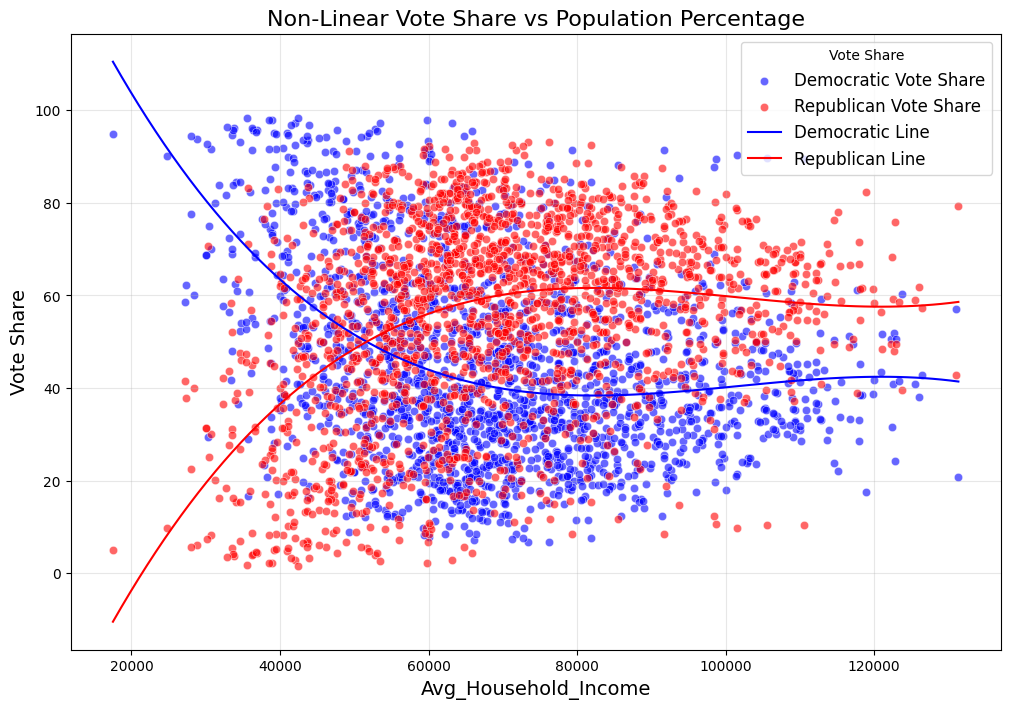

In [10]:
plot_vote_share_vs_population(
    df=black_pop_vote_share_df,
    population_col='Avg_Household_Income',
    dem_col='Democratic_Vote_Share',
    rep_col='Republican_Vote_Share',
    degree=3
)